In [1]:
%pylab nbagg
%load_ext autoreload

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


### Now what would fastCat think of this?

#### We can loop through this

This runs off of a modified xpecgen that returns only the doses and 

In [85]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

dose = 1

# phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
#              'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_hard =  ['air','water','water','water',
             'water','water','water','water']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO-784-micrometer']#,'CuGOS_lowres']

phan_maps = [phan_map_hard]#,phan_map_soft]

angles = np.linspace(0,2*np.pi,2)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,2)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_515()

for phan_map in phan_maps:
    for spectrum_file in spectrum_files:
        for det in dets:
            s = xg.Spectrum()
            s.load(spectrum_file)

            kernel = xg.Kernel(s, det)
            
#             kernel.add_focal_spot(0.1)

            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            res.append(xg.return_projs(phantom.phantom,kernel,
                                       energies,fluence,angles,phantom.geomet,
                                       deposition_efficiency_file=deposition_efficiency_file
                                       ,phantom_mapping = phan_map,
                                       nphoton=None,
                                      dose=dose))

#             img_xg = tigre.algorithms.FDK(
#                 np.transpose(np.array(projs_xg[0]),[0,2,1]), phantom.geomet,angles)

#             res.append([[phan_map,spectrum_file,det],phantom.analyse_515(img_xg[5])])

In [4]:
# np.save('doses_corresponding_to_energies_6',res[0][0])
phantom.phantom.shape

(10, 512, 512)

## Failed attempt

In [147]:
mu_en=[
1.00000E-03,4.078E+03,4.065E+03,
1.50000E-03,1.376E+03,1.372E+03,
2.00000E-03,6.173E+02,6.152E+02,
3.00000E-03,1.929E+02,1.917E+02,
4.00000E-03,8.278E+01,8.191E+01,
5.00000E-03,4.258E+01,4.188E+01,
6.00000E-03,2.464E+01,2.405E+01,
8.00000E-03,1.037E+01,9.915E+00,
1.00000E-02,5.329E+00,4.944E+00,
1.50000E-02,1.673E+00,1.374E+00,
2.00000E-02,8.096E-01,5.503E-01,
3.00000E-02,3.756E-01,1.557E-01,
4.00000E-02,2.683E-01,6.947E-02,
5.00000E-02,2.269E-01,4.223E-02,
6.00000E-02,2.059E-01,3.190E-02,
8.00000E-02,1.837E-01,2.597E-02,
1.00000E-01,1.707E-01,2.546E-02,
1.50000E-01,1.505E-01,2.764E-02,
2.00000E-01,1.370E-01,2.967E-02,
3.00000E-01,1.186E-01,3.192E-02,
4.00000E-01,1.061E-01,3.279E-02,
5.00000E-01,9.687E-02,3.299E-02,
6.00000E-01,8.956E-02,3.284E-02,
8.00000E-01,7.865E-02,3.206E-02,
1.00000E+00,7.072E-02,3.103E-02,
1.25000E+00,6.323E-02,2.965E-02,
1.50000E+00,5.754E-02,2.833E-02,
2.00000E+00,4.942E-02,2.608E-02,
3.00000E+00,3.969E-02,2.281E-02,
4.00000E+00,3.403E-02,2.066E-02,
5.00000E+00,3.031E-02,1.915E-02,
6.00000E+00,2.770E-02,1.806E-02,
8.00000E+00,2.429E-02,1.658E-02,
1.00000E+01,2.219E-02,1.566E-02,
1.50000E+01,1.941E-02,1.441E-02,
2.00000E+01,1.813E-02,1.382E-02]

mu_energies = mu_en[::3]
mu_en_vals = mu_en[2::3]

<IPython.core.display.Javascript object>


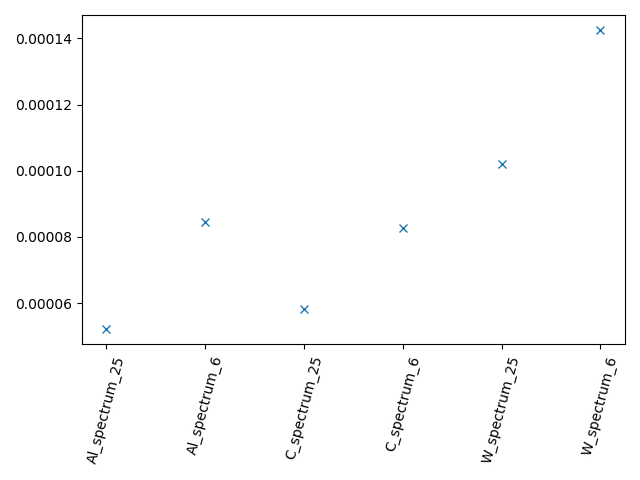

Al_spectrum_25
Al_spectrum_6
6 Al_spectrum_6
C_spectrum_25
C_spectrum_6
6 C_spectrum_6
W_spectrum_25
W_spectrum_6
6 W_spectrum_6


In [253]:
spectrum_files = sorted(['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25'])

plt.figure()

# doses = res[0][0]
doses_fc = []

for jj,spectrum_file in enumerate(spectrum_files):
    
    print(spectrum_file)
    energies = []
    fluence = []

    with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
        for line in f:
            energies.append(float(line.split()[0]))
            fluence.append(float(line.split()[1]))

    # These are what I used in the Monte Carlo
    original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

#     mu_en_water = np.array([0.1557, 0.06947,0.04223,0.03190,0.03800,0.02597,0.02554, 0.02546,0.03192,0.03299,0.03244,0.03150,0.03103,0.02608,0.02066,0.01806])

    # Loading the file from the monte carlo
    deposition_summed = np.load(deposition_efficiency_file,allow_pickle=True)

    # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
    deposition_summed = deposition_summed[0]/(original_energies_keV*355)


    # Binning to get the fluence per energy
    large_energies = np.linspace(0,6000,6001)/1000 #keV
    fluence_large = np.interp(large_energies,np.array(energies), fluence)

    fluence_small = np.zeros(len(original_energies_keV))
    
    mu_en_f = xg.log_interp_1d(mu_energies,mu_en_vals)
    
    mu_en_water = [mu_en_f(energy) for energy in energies]

#     # Still binning
#     for ii, val in enumerate(large_energies):

#         index = np.argmin(np.abs(original_energies_keV-val*1000))
#         fluence_small[index] += fluence_large[ii] 

#     # Normalize
#     fluence_small /= np.sum(fluence_small)

    if np.max(energies) > 3:
        
        doses = np.load('doses_corresponding_to_energies_6.npy')
        print('6',spectrum_file)
    else:
        doses = np.load('doses_corresponding_to_energies_25.npy')

    fluence_small = fluence/np.sum(fluence)

    # Sum over the image dimesions to get the energy intensity and multiply by fluence
    dose_divided_by_initial_intensity = doses@(fluence_small*mu_en_water*0.997)
    
    #plt.plot(jj,doses@(fluence_small*mu_en_water),'x')

    # Mass of the phantom there is a times 4 since the detector is 1/4 the size 1000 for mg
    dose_in_mgrays = dose_divided_by_initial_intensity*1.6021766e-13/2.0106*4*1000
    # Scale by the amount of photons hitting the detector
    
    doses_fc.append(dose_in_mgrays)

plt.plot(doses_fc,'x')    
plt.xticks(ticks=range(len(spectrum_files)),labels=spectrum_files,rotation=75)
plt.tight_layout()

## Working attempt

In [5]:
# plt.figure()
# plt.plot(res[0][0]/original_energies_keV,'x')
# plt.figure()
# plt.loglog(original_energies_keV,mu_en_water,'x')

In [6]:
# mu_en_f = xg.log_interp_1d(mu_energies,mu_en[1::3],'cubic')

# mu_water = [mu_en_f(energy) for energy in original_energies_keV/1000]

In [7]:
# np.round(mu_water,6)

<IPython.core.display.Javascript object>


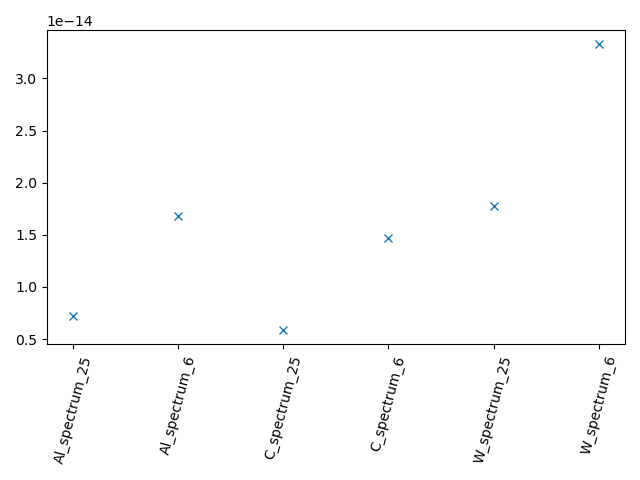

Al_spectrum_25
0.06971849014541585
Al_spectrum_25 4.85324818619069 3180624.7313019307
Al_spectrum_6
0.05785952741805342
Al_spectrum_6 1.7397954309342023 1140192.3336170388
C_spectrum_25
0.07251851016911061
C_spectrum_25 6.235307470221167 4086371.1036841436
C_spectrum_6
0.060973607827171775
C_spectrum_6 2.0974272177525 1374569.9014262785
W_spectrum_25
0.04513862054078589
W_spectrum_25 1.2833368902318139 841047.6643823215
W_spectrum_6
0.03399960849062292
W_spectrum_6 0.5154327838547909 337794.02922707575


In [86]:
spectrum_files = sorted(['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25'])

plt.figure()

doses = res[0][0]
doses_fc = []

# Loading the file from the monte carlo
deposition = np.load(deposition_efficiency_file,allow_pickle=True)

for jj,spectrum_file in enumerate(spectrum_files):
    
    print(spectrum_file)
    energies = []
    fluence = []

    with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
        for line in f:
            energies.append(float(line.split()[0]))
            fluence.append(float(line.split()[1]))

    # These are what I used in the Monte Carlo
    original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

    mu_en_water = array([0.1557  , 0.06947 , 0.04223 , 0.0319  , 0.027678, 0.02597 ,
       0.025434, 0.02546 , 0.03192 , 0.03299 , 0.032501, 0.031562,
       0.03103 , 0.02608 , 0.02066 , 0.01806 ])

    mu_water = np.array([0.3756  , 0.2683  , 0.2269  , 0.2059  , 0.19289 , 0.1837  ,
       0.176564, 0.1707  , 0.1186  , 0.09687 , 0.083614, 0.074411,
       0.07072 , 0.04942 , 0.03403 , 0.0277  ])
    
    mu_woutcoherent_water = np.array([3.286E-01  , 2.395E-01   , 2.076E-01 , 1.920E-01  , 1.824E-01 , 1.755E-01  ,
        1.700E-01, 1.654E-01 , 1.180E-01 , 9.665E-02 , 8.351E-02, 7.434E-02,
        7.066E-02 , 4.940E-02 , 0.03402 , 0.0277  ])

    # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
    deposition_summed = deposition[0]/(original_energies_keV/1000)/1000000

    
    fluence_norm = fluence/np.sum(fluence)
    
    deposition_long = np.interp(energies,original_energies_keV/1000,deposition_summed)
    
    nphotons_at_energy = fluence_norm*deposition_long
    
    nphotons_av = np.sum(nphotons_at_energy)
    
    print(nphotons_av)

#     deposition_scale = np.trapz(fluence_original*deposition_summed,original_energies_keV)
    
    # Binning to get the fluence per energy
    large_energies = np.linspace(0,6000,3001)/1000 #keV
    fluence_large = np.interp(large_energies,np.array(energies), fluence)

    fluence_small = np.zeros(len(original_energies_keV))

    # Still binning
    for ii, val in enumerate(large_energies):

        index = np.argmin(np.abs(original_energies_keV-val*1000))
        fluence_small[index] += fluence_large[ii] 

    # Normalize
    fluence_small /= np.sum(fluence_small)

    # Sum over the image dimesions to get the energy intensity and multiply by fluence
    dose_divided_by_initial_intensity = (mu_en_water/mu_water*doses)@((fluence_small))#*0.027*0.997)
    

    #plt.plot(jj,doses@(fluence_small*mu_en_water),'x')

    # Mass of the phantom there is a times 4 since the detector is 1/4 the size 1000 for mg
    dose_in_mgrays = dose_divided_by_initial_intensity * 1.6021766e-16
    # Scale by the amount of photons hitting the detector
    
    nphotons = 3.304057543118688e-07/dose_in_mgrays
    # This should adjust to the number that reach the detector
    nphotons *= nphotons_av # Nope
    # We then divide by the number of pixels to get the final product
    nphotons_per_voxel = nphotons/(10*128*phantom.phantom.shape[2])  
    
    print(spectrum_file,nphotons_per_voxel,nphotons)
    doses_fc.append(dose_in_mgrays)

plt.plot(doses_fc,'x')    
plt.xticks(ticks=range(len(spectrum_files)),labels=spectrum_files,rotation=75)
plt.tight_layout()

In [73]:
doses

array([  17.475273,   22.363644,   27.190601,   32.047333,   36.94688 ,
         41.744446,   46.555008,   51.301434,  136.21332 ,  206.97165 ,
        268.19025 ,  322.691   ,  347.9621  ,  549.7175  ,  830.9065  ,
       1055.5598  ], dtype=float32)

In [87]:
doses = np.array([
1.613708349168519e-07,
1.313530049174005e-07,
6.200432949299284e-07,
3.304057543118688e-07,
2.999242099122057e-07,
3.515523019359534e-07,
])

names = np.array([
'Dose_Al_spectrum_25'  ,
'Dose_C_spectrum_25'  ,
'Dose_W_spectrum_6',
'Dose_Al_spectrum_6'  , 
'Dose_C_spectrum_6',
'Dose_W_spectrum_25'])

indeces = np.argsort(names)


names = names[indeces]
doses = doses[indeces]

indeces = np.argsort(doses)

names = names[indeces]
doses = doses[indeces]


<IPython.core.display.Javascript object>


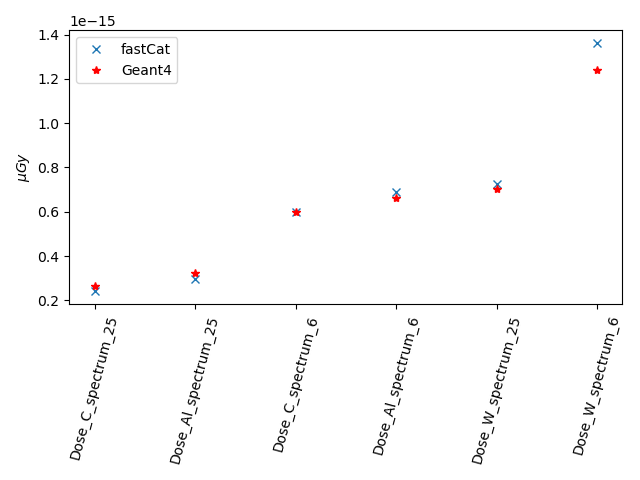

In [92]:
import pandas as pd

d_norm = doses#/sum(doses)

doses_fc2 = np.array(doses_fc)
doses_fc2 = doses_fc2[indeces]#/(5*7.5)#(doses_fc2[indeces]-np.min(doses_fc2))
# doses_fc2 = doses_fc2/np.max(doses_fc2)*np.max(d_norm)
# doses_fc2 += np.min(d_norm)

# doses_fc2 = np.delete(doses_fc2,4)
# d_norm = np.delete(d_norm,4)

dat = pd.DataFrame(d_norm/500000000,index=names)#np.delete(names,4))

plt.figure()
plt.plot(doses_fc2*0.041,'x')
plt.plot(dat,'r*')
# plt.plot(doses_fc/sum(doses_fc),'x')
plt.xticks(rotation=75)
plt.ylabel('$\mu Gy$')
plt.legend(['fastCat','Geant4'])
plt.tight_layout()

In [394]:
plt.savefig('Dose Comparison Better')

In [54]:
from scipy.optimize import minimize

In [317]:
minimize(min_fun,7.5,method='COBYLA'  )

     fun: 5.750438771649163e-17
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array(0.02681133)

In [310]:
def min_fun(x):
    
    return np.sum(np.abs((doses_fc2)*np.exp(-x*doses_fc2)-d_norm*7.5))

In [316]:
def min_fun(x):
    
    return np.sum(np.abs(doses_fc2*x-d_norm/500000000))

In [108]:
x = 5

np.sum(np.abs(np.array(doses_fc)**x-np.array(doses)/np.sum(doses)))

1.0

In [109]:
min_fun(1.23)

0.7929858306156738

<IPython.core.display.Javascript object>


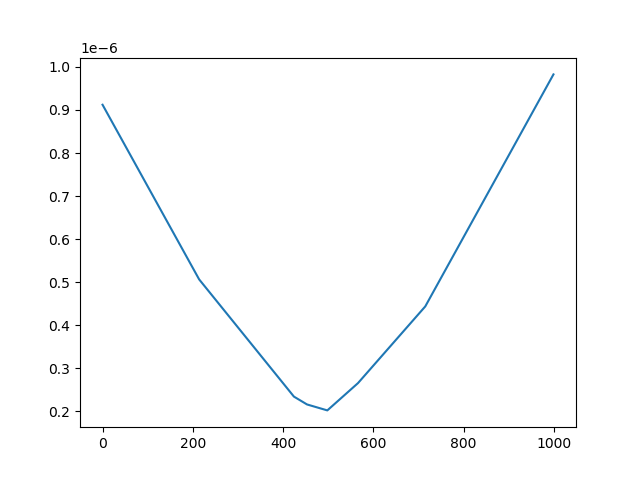

In [89]:
plt.figure()
plt.plot([min_fun(ii) for ii in np.linspace(7.,8.,1000)])

In [111]:
np.linspace(0.1,10,100)[27]

2.8000000000000003

<IPython.core.display.Javascript object>


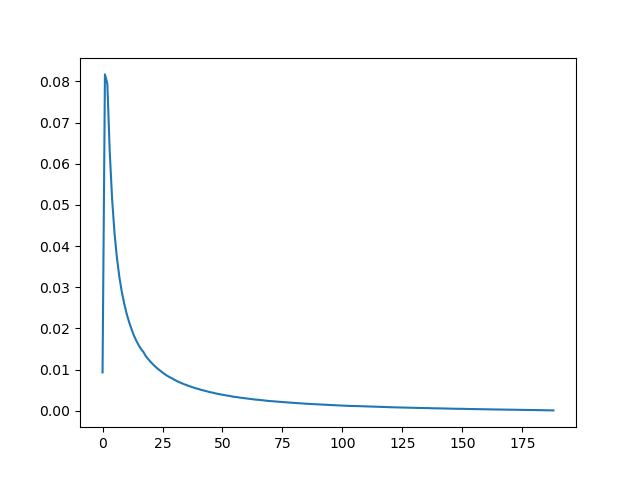

In [93]:
plt.figure()
plt.plot([0.00932948226572424 ,0.08168943504840458 ,0.0794005993790592 ,0.06285985738122206 ,0.05131660250882283 ,0.04306470340452115 ,0.03710835702215279 ,0.032547478314931905 ,0.028977364864434266 ,0.026110862672524826 ,0.02367761037253843 ,0.021682645753916045 ,0.019976514396575686 ,0.018401365564700435 ,0.017120087783548177 ,0.016002370232912604 ,0.015023695670847683 ,0.014328648654309124 ,0.013314373713528045 ,0.012585741434049717 ,0.011913028617366107 ,0.01130765425287674 ,0.010744765246006182 ,0.010220163438886962 ,0.009759205705038607 ,0.009320246318415801 ,0.008889347394898543 ,0.008495728113244429 ,0.008163234010140697 ,0.007874736601488066 ,0.0075387160457756576 ,0.007212267290001085 ,0.00695953818637931 ,0.006720075261618743 ,0.006458446063317929 ,0.006258613748826292 ,0.006025867876653681 ,0.005829226162141324 ,0.005628218363446795 ,0.0054460183119985385 ,0.005303952649763308 ,0.005118897850965171 ,0.004965581125645116 ,0.004789762274155417 ,0.0046419871172204245 ,0.004507478139146643 ,0.00440521101349504 ,0.0042498791723986 ,0.004146100709914709 ,0.004018812563372977 ,0.003903615111489563 ,0.0037932875227324153 ,0.0036990808601863588 ,0.0036226743869983797 ,0.003479433240560257 ,0.0033968134937284213 ,0.0033422374414512936 ,0.0032272079158825783 ,0.0031543278953032753 ,0.00308329506418566 ,0.0030033621383890054 ,0.0029392142861740436 ,0.0028471906657190718 ,0.002784050371392303 ,0.0027173836244568576 ,0.002678760572076121 ,0.0026102466356789887 ,0.002541564772967157 ,0.002482118857563763 ,0.0024129332159078354 ,0.0023756535740446895 ,0.0023417324584755206 ,0.002275401564169473 ,0.002224016111871624 ,0.002172966512203173 ,0.0021336717545636405 ,0.0020797674075453084 ,0.002044838734087947 ,0.002002353376469137 ,0.0019541585241505655 ,0.0019089863454965735 ,0.0018592801563457127 ,0.0018204891776502775 ,0.0017780038200314674 ,0.0017471053781268782 ,0.0017192296098868683 ,0.0016943765153114379 ,0.0016436795609038538 ,0.0016199683652683757 ,0.0015935199707033062 ,0.001563494745635151 ,0.001518792760662316 ,0.0015016642765630329 ,0.001479514795654254 ,0.0014505642990001717 ,0.0014021007645780826 ,0.0013799848689322433 ,0.0013534189259468848 ,0.001326584300858008 ,0.00131603852829492 ,0.0012847034779721136 ,0.001241848682460966 ,0.0012354842751338797 ,0.001187490934392947 ,0.001191302861736611 ,0.0011742919260576171 ,0.001154090390399345 ,0.0011232087411262256 ,0.0011116218254120045 ,0.0010882968603003337 ,0.0010503958910728025 ,0.0010357023385366528 ,0.001009472248180692 ,0.0009918735704002519 ,0.0009875074862180815 ,0.0009667853789842429 ,0.0009519910706592739 ,0.0009320582171045198 ,0.0009179356140383463 ,0.0008955174510260492 ,0.0008843167658356356 ,0.0008603536807281092 ,0.0008381370292934508 ,0.0008251899104301691 ,0.000819631549413637 ,0.0007991445390203767 ,0.0007894719832937228 ,0.000770244420260704 ,0.0007692368623725109 ,0.0007422007257059954 ,0.0007313191005135098 ,0.0007064156280436698 ,0.0006997321607186553 ,0.0006941066291762437 ,0.0006710167609051513 ,0.0006598328683462075 ,0.0006622677999093409 ,0.0006281787580254735 ,0.0006220830328019051 ,0.0006058781434334657 ,0.0005978344729593906 ,0.0005778848267731667 ,0.00057741463309201 ,0.0005607731353053535 ,0.0005385900691336348 ,0.0005337034133758982 ,0.0005329645375912233 ,0.0005051223546141532 ,0.0005045681977756469 ,0.00048623064421053207 ,0.00048602913263289346 ,0.0004673053485439712 ,0.00044962270760618187 ,0.00044466888132256566 ,0.00043230950456073 ,0.00042406432250901633 ,0.00041600385940347126 ,0.0004091020878693484 ,0.00039424060901849977 ,0.0003797821533229284 ,0.00037598701861073436 ,0.00036456802921121234 ,0.00036408104289858566 ,0.00035118430192971364 ,0.0003340894030933703 ,0.00032858141997124787 ,0.0003100087695655546 ,0.0002963899454434775 ,0.00029514729071470605 ,0.0002893034549631859 ,0.0002755670824208196 ,0.0002750297182137833 ,0.000264517530913635 ,0.000246935645764665 ,0.0002452563826176765 ,0.00022989112482273128 ,0.0002242320080173799 ,0.00020708673128662686 ,0.00019887513449785293 ,0.00019449225768421283 ,0.00018092381145654542 ,0.00016960557784584265 ,0.0001644015413533252 ,0.00015095400207224094 ,0.00014360218801472512 ,0.00013753501026465552 ,0.00012536706950157654 ,0.00012026714732417233 ,0.0001049573052130778])